# LSTM Classifier

In [2]:
# Libraries
import os
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy import stats

path_pardir = Path(os.getcwd())
path_data = os.path.join(path_pardir, 'data')
path_model = os.path.join(path_pardir, 'weights')

print("Path to data: ", path_data)
print("Path to models: ", path_model)

# Check and generate the data folder
if not os.path.isdir(path_data):
    os.mkdir(path_data)
if not os.path.isdir(path_model):
    os.mkdir(path_model)

# Check for GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

Path to data:  /home/leo/Desktop/temperature_ws/src/temperature_ros/config/net/data
Path to models:  /home/leo/Desktop/temperature_ws/src/temperature_ros/config/net/weights
Device: cuda


## Split Dataset trough Stratification technique
In this section it is implemented a stratified approach to split the overall dataset into balanced train (80%), validation (10%) and test (10%) datasets. The stratification was intended to ensure the representation in all subset the following characteristics
- 8 different level of indenting depth (0-0.5, 0.5-1, 1-1.5, 1.5-2, 2-2.5, 2.5-3, 3-3.5, 3.5-4)
- 4 tissue class (C1, C2, C3, C4)



In [4]:
# Dataset definition:
class MaterialDataset(Dataset):
    """Dataset for material classification based on temperature time series."""
    def __init__(self, path_to_csv:str, which=1):
        annotations_files = [f for f in os.listdir(path_to_csv) if f.endswith('.csv')]
        annotations_files.sort()
        # Check if the dataset is for training or testing # 0 full dataset, 1 augmented, 2 train, 3 test
        self.which = which
        # Initialize DataFrames
        self.df = pd.DataFrame(columns=["Timeseries ID","Experiment","Timestamp","temperature [C]","delta_t [C/s]","Label","notes"])
        self.augmented_df = pd.DataFrame(columns=["Timeseries ID","Experiment","Timestamp","temperature [C]","delta_t [C/s]","Label","notes"])
        self.df_train = pd.DataFrame()
        self.df_test = pd.DataFrame()

        self.class_names = []

        # Load all annotations files
        for file_idx, file in enumerate(annotations_files):
            # iterate over each tissue file
            curr_df = pd.read_csv(os.path.join(path_to_csv, file))

            self.class_names.append(os.path.splitext(os.path.basename(file))[0])
            #self.class_names.append(curr_df['notes'].dropna().unique().astype(str))         # Get dataset labelized name

            # Assign numeric labels to the current DataFrame
            curr_df["Label"] = [file_idx] * len(curr_df)
            self.df = pd.concat([self.df, curr_df], ignore_index=True)
        
        # Assign timeseries ID
        group_cols = ['Experiment', 'Label']
        df_groups = self.df.groupby(group_cols)
        for timeseries_id, (group_key, group_indices) in enumerate(df_groups.groups.items()):
            # Assign the Timeseries ID back to df
            self.df.loc[group_indices, 'Timeseries ID'] = timeseries_id
            # Shift 'Timestamp' to t0=0 at each experiment and convert into seconds
            self.df.loc[group_indices, 'Timestamp'] = 1e-9*(self.df.loc[group_indices, 'Timestamp'] - self.df.loc[group_indices, 'Timestamp'].min())
    
    def merge(self, df1:pd.DataFrame, df2:pd.DataFrame, save_path):
        experiment_shift = df1['Experiment'].max()
        df2['Experiment'] = df2['Experiment'] + experiment_shift 
        merged_df = pd.concat([df1, df2], ignore_index=True)
        merged_df.to_csv(save_path+'/merged.csv', index=False)

    def split(self, augmented = True, test_size=0.2, random_state=42):
        # Split the DataFrame into training and test sets
        df = self.augmented_df if augmented else self.df

        train_df, test_df = train_test_split(df, test_size, random_state, stratify=df[['Timeseries ID','Label']])
        self.train_df = train_df.sort_values(by=['Timeseries ID','Timestamp']).reset_index(drop=True)
        self.test_df = test_df.sort_values(by=['Timeseries ID','Timestamp']).reset_index(drop=True)
    
    def data_augmentation(self, times=10, noise_std=0.001):
        self.augmented_df = pd.DataFrame(columns=["Timeseries ID","Experiment","Timestamp","temperature [C]","delta_t [C/s]","Label","notes"])
        # Create new DataFrame for subsamples
        tmp_df = pd.DataFrame(columns=["subsample","Timeseries ID","Experiment","Timestamp","temperature [C]","delta_t [C/s]","Label","notes"])
        tmp_df = pd.concat([tmp_df, self.df], ignore_index=True)

        seq = np.arange(1, times+1)
        repeated_seq = np.tile(seq, int(np.ceil(len(tmp_df) / len(seq))))[:len(tmp_df)]
        tmp_df['subsample'] = repeated_seq

        # Group by timeseries and subsamples
        tmp2_df = pd.DataFrame(columns=["subsample","Timeseries ID","Experiment","Timestamp","temperature [C]","delta_t [C/s]","Label","notes"])
        group_cols = ['Timeseries ID', 'subsample']
        df_groups = tmp_df.groupby(group_cols)
        for timeseries_id, (group_key, group_indices) in enumerate(df_groups.groups.items()):
            # Assign the Timeseries ID back to df
            group_df = self.df.loc[group_indices]
            group_df['Timeseries ID'] = timeseries_id
            tmp2_df = pd.concat([tmp2_df, group_df], ignore_index=True)

        # Perturbate each timeserie with gaussian noise        
        tmp2_df['temperature [C]'] = tmp2_df['temperature [C]'] + np.random.normal(0, noise_std, size=len(tmp2_df['temperature [C]']))

        # Store the augmented DataFrame
        self.augmented_df = tmp2_df[["Timeseries ID","Experiment","Timestamp","temperature [C]","delta_t [C/s]","Label","notes"]]
        self.augmented_df = self.augmented_df.sort_values(by=['Timeseries ID','Timestamp']).reset_index(drop=True)
        
        #-----
        # shift t0
        #tmp3_df = self.augmented_df.copy()
        #group_cols = ['Timeseries ID']
        #df_groups = tmp3_df.groupby(group_cols)
        #for timeseries_id, (group_key, group_indices) in enumerate(df_groups.groups.items()):
        #    # Get timeseries
        #    group_df = self.augmented_df.loc[group_indices]
        #    for i in range(int(times/2)):
        #        # set new Timemseries ID
        #        group_df['Timeseries ID'] = len(df_groups.groups.items()) + timeseries_id*int(times/2) + i
        #        # set new temperature
        #        A_s = np.random.normal(0, 0.01, size=1)
        #        s = A_s * np.exp(-0.2 * np.arange(1, len(group_df['temperature [C]'])+1))
        #        group_df['temperature [C]'] = group_df['temperature [C]'] + s
        #        # append
        #
        #        tmp3_df = pd.concat([tmp3_df, group_df], ignore_index=True)
        #self.augmented_df = tmp3_df[["Timeseries ID","Experiment","Timestamp","temperature [C]","delta_t [C/s]","Label","notes"]]
        #self.augmented_df = self.augmented_df.sort_values(by=['Timeseries ID','Timestamp']).reset_index(drop=True)
        

    def resample(self, timeseries:np.array, timestamp:np.array, frequency=10):    
        duration = (timestamp[-1] - timestamp[0])
        # Resample the timeseries to the specified frequency
        resampled_timestamp = np.linspace(timestamp[0], timestamp[-1], int(np.ceil(frequency * duration)))
        resampled_timeseries = np.interp(resampled_timestamp, timestamp, timeseries)
        return (resampled_timeseries, resampled_timestamp)
    

    def plot(self):    
        plotted_labels = []
        sizes = [0, 0, 0, 0]
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.class_names)))
        plt.figure()
        for i in range(len(self)):
            item = self[i]
            seq = item[0].numpy()
            lbl = item[1].item()
            seq = seq[:,0].reshape((len(seq[:,0]),))
            # Get the label name from the categorical codes 
            label_name = self.class_names[lbl]
            #increment dataset counter
            sizes[lbl] += 1
            # Plot the sequence with the label name
            if label_name not in plotted_labels:
                plt.plot(seq, color=colors[lbl], label=label_name)
                plotted_labels.append(label_name)
            else:
                plt.plot(seq, color=colors[lbl], label='_nolegend_')
        plt.xlabel('Time Step')
        plt.ylabel('Temperature (C)')
        plt.title('Training Sequences: Temperature over Time')
        plt.legend(title="Class", loc="upper right")
        plt.show()
        
        # Create the pie chart
        plt.figure(figsize=(6, 6))
        plt.pie(sizes, labels=self.class_names, autopct='%1.1f%%', startangle=90)
        plt.title('Data')
        plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle
        plt.show()

    def __len__(self):
        # Load timeseries
        if self.which == 1:
            df = self.augmented_df
        elif self.which == 2:
            df = self.df_train
        elif self.which == 3:
            df = self.df_test
        else:
            df = self.df
            
        return df['Timeseries ID'].values.max() + 1  # Return the maximum Timeseries ID + 1

    def __getitem__(self, idx):
        # Load timeseries
        if self.which == 1:
            df = self.augmented_df
        elif self.which == 2:
            df = self.train_df
        elif self.which == 3:
            df = self.test_df
        else:
            df = self.df

        
        raw_seq = np.array(df.loc[df['Timeseries ID'] == idx, 'temperature [C]'].values).astype(float)
        draw_seq = np.array(df.loc[df['Timeseries ID'] == idx, 'delta_t [C/s]'].values).astype(float)
        #raw_seq = np.array(df.loc[df['Timeseries ID'] == idx, 'delta_t [C/s]'].values).astype(float)
        raw_times = np.array(df.loc[df['Timeseries ID'] == idx, 'Timestamp'].values).astype(float)
        # Convert to interpolated features
        (seq,_) = self.resample(raw_seq, raw_times)
        (dseq,_) = self.resample(draw_seq, raw_times)

        # Tensorize the sequence
        seq = seq.reshape((len(seq),1))
        dseq = dseq.reshape((len(dseq),1))
        features = torch.tensor(np.hstack((seq,dseq)), dtype=torch.float32)   
        label = df.loc[df['Timeseries ID'] == idx, 'Label'].values[0]
        
        return features, torch.tensor(label, dtype=torch.long)
    

# Plot Dataset

In [70]:
dataset_manager_test = MaterialDataset(path_data + '/test', which=0)
dataset_manager_test[0]

C:\Users\leona\AppData\Local\Temp\ipykernel_14500\4025283524.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, curr_df], ignore_index=True)


(tensor([[ 1.0660e+00, -7.3330e-03],
         [ 1.0610e+00, -1.9928e-02],
         [ 1.0551e+00, -3.5122e-02],
         [ 1.0481e+00, -5.1996e-02],
         [ 1.0430e+00, -6.4625e-02],
         [ 1.0370e+00, -7.5767e-02],
         [ 1.0330e+00, -8.1654e-02],
         [ 1.0290e+00, -8.4382e-02],
         [ 1.0240e+00, -8.7113e-02],
         [ 1.0200e+00, -8.7815e-02],
         [ 1.0170e+00, -8.5679e-02],
         [ 1.0140e+00, -8.2320e-02],
         [ 1.0110e+00, -7.8661e-02],
         [ 1.0060e+00, -7.8762e-02],
         [ 1.0050e+00, -7.3583e-02],
         [ 1.0040e+00, -7.0773e-02],
         [ 1.0030e+00, -6.7984e-02],
         [ 1.0010e+00, -6.2753e-02],
         [ 9.9703e-01, -6.1703e-02],
         [ 9.9601e-01, -5.7477e-02],
         [ 9.9501e-01, -5.2034e-02],
         [ 9.9302e-01, -4.8269e-02],
         [ 9.9101e-01, -4.5677e-02],
         [ 9.9001e-01, -4.2117e-02],
         [ 9.8901e-01, -3.8384e-02],
         [ 9.8702e-01, -3.6678e-02],
         [ 9.8502e-01, -3.6144e-02],
 

/tmp/ipykernel_14843/3924738139.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, curr_df], ignore_index=True)
/tmp/ipykernel_14843/3924738139.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, curr_df], ignore_index=True)
/tmp/ipykernel_14843/3924738139.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns w

Test: 75


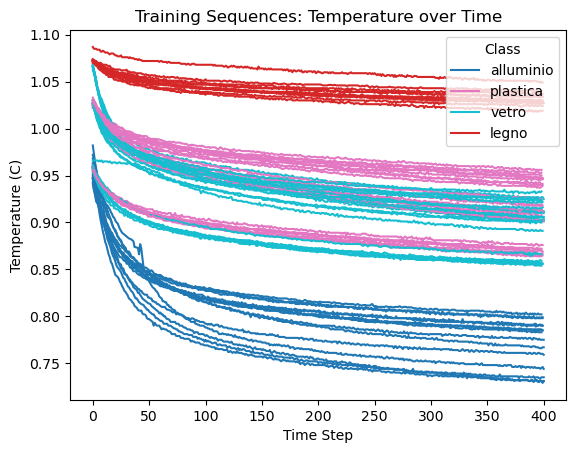

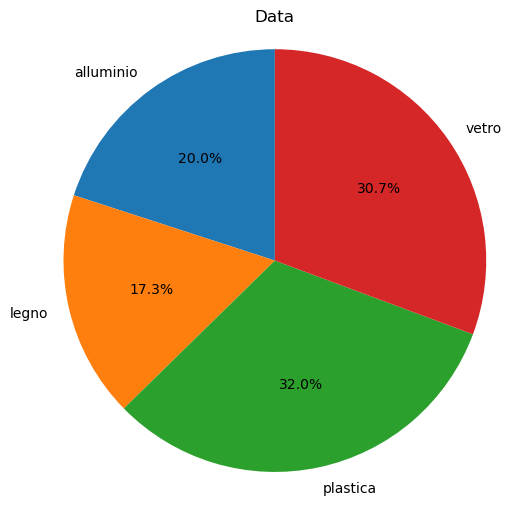

Training: 690


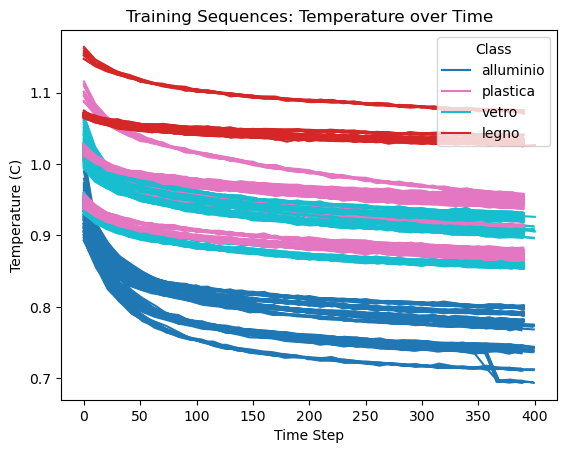

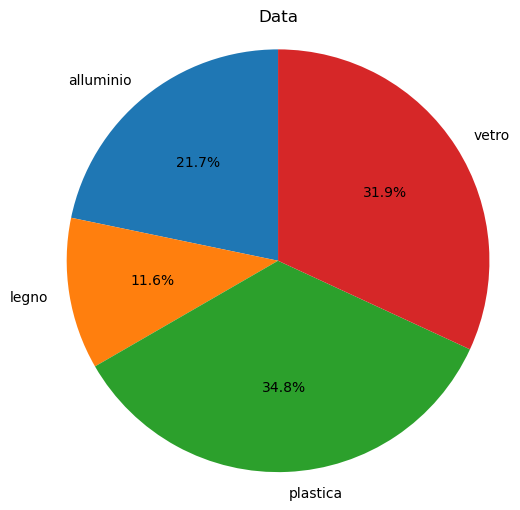

In [5]:
dataset_manager_test = MaterialDataset(path_data + '/test', which=0)
dataset_manager_train = MaterialDataset(path_data + '/train', which=1)
dataset_manager_train.data_augmentation(times=10)

print(f"Test: {len(dataset_manager_test)}")
dataset_manager_test.plot()
print(f"Training: {len(dataset_manager_train)}")
dataset_manager_train.plot()

In [ ]:
dataset_manager_train.augmented_df
#dataset_manager_aug.augmented_df.to_csv('/home/leo/Desktop/temperature_ws/src/temperature_ros/config/net/data'+'/test.csv', index=False)

,Timeseries ID,Experiment,Timestamp,temperature [C],delta_t [C/s],Label,notes
0,0,1,0.0,1.011661,0.016452,0,"alluminio, thick 2mm, temp 38C"
1,0,1,1.000655,0.920414,-0.072752,0,"alluminio, thick 2mm, temp 38C"
2,0,1,2.100376,0.876013,-0.047668,0,"alluminio, thick 2mm, temp 38C"
3,0,1,3.100823,0.840957,-0.029729,0,"alluminio, thick 2mm, temp 38C"
4,0,1,4.20084,0.823074,-0.020486,0,"alluminio, thick 2mm, temp 38C"
...,...,...,...,...,...,...,...
91573,2399,10,35.500921,0.918013,-0.000981,3,"vetro, thick 1mm, temp 38C"
91574,2399,10,36.500947,0.915832,0.000674,3,"vetro, thick 1mm, temp 38C"
91575,2399,10,37.600952,0.913894,-0.002870,3,"vetro, thick 1mm, temp 38C"
91576,2399,10,38.600961,0.914456,-0.001326,3,"vetro, thick 1mm, temp 38C"


In [35]:
path = '/home/leo/Desktop/temperature_ws/src/temperature_ros/config/net/data/ori'
path = os.path.join(path_pardir, 'data', 'ori')
"""
exp_materials_08072025132512 - vetro
exp_materials_08072025140035 - alluminio
exp_materials_08072025141957 - legno
exp_materials_14072025094057 - alluminio
exp_materials_14072025101847 - legno
exp_materials_14072025110412 - plastica
exp_materials_14072025131533 - plastica
exp_materials_14072025134149 - plastica
exp_materials_14072025140425 - vetro
exp_materials_14072025145057 - alluminio
exp_materials_14072025152352 - alluminio
exp_materials_14072025155724 - plastica
exp_materials_14072025162747 - vetro 
"""


df1 = pd.read_csv(os.path.join(path,'merged.csv'))
df2 = pd.read_csv(os.path.join(path, 'exp_materials_14072025155724.csv'))

dataset_manager_test.merge(df1, df2, path)

In [38]:
path = os.path.join(path_pardir, 'data','test')
name = 'merged_alluminio.csv'
df = pd.read_csv(os.path.join(path,name))

mask = (df["Experiment"] % 2 == 0)
df = df[~mask]

df.to_csv(os.path.join(path, name), index=False)


# LSTM Network


In [6]:
class LSTMNet(nn.Module):
    def __init__(self, num_features=1, num_hidden1=125, num_hidden2=100, num_classes=6, dropout=0.2):
        super(LSTMNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size=num_features, hidden_size=num_hidden1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=num_hidden1, hidden_size=num_hidden2, batch_first=True, bidirectional=False)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(num_hidden2, num_classes)

    
    def forward(self, x, lengths = None):
        # x: (batch, seq_len, num_features)
        # lengths: (batch,)  -- original lengths before padding
        if lengths is None:
            # x shape: (batch, seq_len, num_features)
            out, _ = self.lstm1(x)
            out = self.dropout1(out)
            # Only take last time step output from second LSTM
            out, _ = self.lstm2(out)
            out = self.dropout2(out)
            out = out[:, -1, :]  # last time step
            out = self.fc(out)
        else:
            # Pack the padded sequence
            x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

            # LSTM 1
            out_packed, _ = self.lstm1(x_packed)
            out_padded, _ = pad_packed_sequence(out_packed, batch_first=True)
            out_padded = self.dropout1(out_padded)

            # Pack again before 2nd LSTM
            out_packed = pack_padded_sequence(out_padded, lengths.cpu(), batch_first=True, enforce_sorted=False)
            out_packed, (h_n, c_n) = self.lstm2(out_packed)
            out_padded, _ = pad_packed_sequence(out_packed, batch_first=True)
            out_padded = self.dropout2(out_padded)

            # Use last valid time step for each sequence
            # (lengths - 1) because of 0-indexing
            idx = (lengths - 1).view(-1, 1, 1).expand(-1, 1, out_padded.size(2))
            last_outputs = out_padded.gather(1, idx).squeeze(1)  # shape: (batch, hidden_size)

            out = self.fc(last_outputs)

        return out                         # use linear output if using CrossEntropyLoss
        #return F.log_softmax(out, dim=1)  # use log_softmax if using NLLLoss

        
    """
    def __init__(self, num_features=1, num_hidden1=125, num_hidden2=100, num_classes=6, dropout=0.2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=num_hidden1, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(num_hidden1, num_classes)
    def forward(self, x, lengths = None):
        # x: (batch, seq_len, num_features)
        # lengths: (batch,)  -- original lengths before padding
        if lengths is None:
            # x shape: (batch, seq_len, num_features)
            out, _ = self.lstm(x)
            out = out[:, -1, :]  # last time step
            out = self.fc(out)
        else:
            # Pack the padded sequence
            x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

            # LSTM 1
            out_packed, _ = self.lstm(x_packed)
            out_padded, _ = pad_packed_sequence(out_packed, batch_first=True)

            # (lengths - 1) because of 0-indexing
            idx = (lengths - 1).view(-1, 1, 1).expand(-1, 1, out_padded.size(2))
            last_outputs = out_padded.gather(1, idx).squeeze(1)  # shape: (batch, hidden_size)

            out = self.fc(last_outputs)

        return out                         # use linear output if using CrossEntropyLoss
        #return F.log_softmax(out, dim=1)  # use log_softmax if using NLLLoss
    """

In [9]:
class MaterialClassifier():
    """
    
    """
    def __init__(self, dataset:MaterialDataset, path_name = None, num_features=1, num_hidden1=125, num_hidden2=100, num_classes=6):
        # Dataset manager
        self.dataset_manager = dataset

        # Check for GPUs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device:",self.device)
        
        # Istanciate LSTM Network
        self.lstm = LSTMNet(num_features, num_hidden1, num_hidden2, num_classes=len(self.dataset_manager.class_names))
        self.lstm.to(self.device)
        self.lstm = self.lstm.float()

        if path_name is None:
            self.path_name = '/home/leo/Desktop/temperature_ws/src/temperature_ros/config/net/weights/'
        else: 
            self.path_name = path_name

    def load(self, name:str):
        #torch.load(self.path_name + name + '.pt', weights_only=False)
        self.lstm.load_state_dict(torch.load(self.path_name + name + '.pt', weights_only=False))
        self.lstm.eval()

    def save(self, name:str):
        torch.save(self.lstm.state_dict(), self.path_name + name + '.pt')
        print("weight saved at: " + self.path_name + name + '.pt')

    def predict(self, timeseries:np.array):
        """
        timeseries np.array where 
            timeseries[:,i] = i-th features, 
            timeseries[:, -1] = times in [s]
        """

        with torch.no_grad():
            t_data = timeseries[:, -1]
            x_input = np.zeros((len(t_data), self.dataset_manager.num_features))  # Initialize input array
            
            for i in self.num_features:
                x_data = timeseries[:,i]
                x_input[:,i], _ = self.dataset_manager.resample(x_data, t_data, frequency = 10) # resample at 10Hz

            # Tensorize and prepare the input sequence
            x_input = x_input.reshape((1, len(t_data), self.num_features))
            x_input = torch.tensor(x_input, dtype=torch.float32)   
            x_input = x_input.to(self.device)

            # Forward pass (model calls)
            logits_model = self.lstm(x_input)
            # Select the highest value among possible logits
            predicted_scores = F.softmax(logits_model, dim=1).to('cpu')
            predicted_class = torch.argmax(logits_model).to('cpu')
        
            return (predicted_class.numpy(), predicted_scores.numpy()[0])

    def train(self, training_dataset:MaterialDataset, validation_dataset:MaterialDataset, n_epochs = 100, batch_size = 1, lr=1e-3, gamma=0.9):
        # Training parameters
        learning_rate = lr
        optimizer = optim.Adam(self.lstm.parameters(), lr = learning_rate)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

        #criterion = nn.NLLLoss()  # for classification with SoftMax included
        loss_fn = nn.CrossEntropyLoss()

        # load dataset
        training_dataloader = DataLoader(training_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         collate_fn=self.collate_fn)
        validation_dataloader = DataLoader(validation_dataset, 
                                           batch_size=1, 
                                           shuffle=False,
                                           collate_fn=self.collate_fn)

        training_loss_list = []
        training_accuracy_list = []
        validation_loss_list = []
        
        # Iterate over the epochs:
        for epoch in range(n_epochs):

            # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
            self.lstm.train()  

            # Temporary variable to store the loss on the whole epoch as a convergence metric
            running_loss = 0.0
            training_accuracy = 0.0

            # Iterate on the whole dataset using the dataloader.
            for x_input, lengths, label_gt in training_dataloader:
                # Load inputs ad move to device (GPU)
                x_input, label_gt = x_input.to(self.device), label_gt.to(self.device)
                lengths = lengths.to(self.device)
                #print(x_input)
                # Clear previous gradients
                optimizer.zero_grad()  
                

                # Forward pass (model calls)
                #logits_model = self.lstm(x_input, lengths)  
                # Compute loss (supervised case)
                #loss = loss_fn(logits_model, label_gt)  
                with torch.amp.autocast(str(self.device)):  # if using AMP
                    logits_model = self.lstm(x_input, lengths)
                    loss = loss_fn(logits_model, label_gt)

                # Backpropagation 
                loss.backward()  

                # Update parameters (optimization step)
                optimizer.step()  

                # Update running loss as convergence metric
                running_loss += loss.item()
                
                # update accuracy
                y_pred = torch.argmax(logits_model,dim=1)
                training_accuracy += (y_pred == label_gt).int().to('cpu').numpy().sum()/batch_size

            # Step the learning rate scheduler
            scheduler.step()  

            ## Calculate loss on validation as an additional metric to evaluate overfitting
            # Set the model to Evaluation mode:
            self.lstm.eval()

            # Temporary variable to store the validation loss:
            running_val_loss = 0.0
            
            # Deactivate gradient computation
            with torch.no_grad():
                for x_input, _, label_gt in validation_dataloader:
                    # Load inputs ad move to device (GPU)
                    x_input, label_gt = x_input.to(self.device), label_gt.to(self.device)

                    # Forward pass (model calls)
                    logits_model = self.lstm(x_input)

                    # Compute loss (supervised case)
                    loss = loss_fn(logits_model, label_gt)

                    # Update validation running loss as convergence metric
                    running_val_loss += loss.item()
                    
            # Average epoch loss
            epoch_training_loss = running_loss / len(training_dataloader)
            epoch_training_accuracy = training_accuracy/ len(training_dataloader)*100
            epoch_validation_loss = running_val_loss / len(validation_dataloader)

            # Append the losses to the list:
            training_loss_list.append(epoch_training_loss)
            training_accuracy_list.append(epoch_training_accuracy)
            validation_loss_list.append(epoch_validation_loss)            

            # Convergence metric
            if epoch%50==0:
                # Save checkpoint
                checkpoint = {
                    'epoch': epoch + 1, # Save the next epoch number to start from
                    'model_state_dict': self.lstm.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': training_loss_list,
                    'validation loss': validation_loss_list
                }
                torch.save(checkpoint, self.path_name + '/checkpoints/checkpoint_' + datetime.now().strftime("%d%m%Y%H%M%S") + '.pth')

                print(f"[Checkpoint] Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Accuracy: {epoch_training_accuracy:.0f}%, Val. Loss: {epoch_validation_loss:.4f}")
            else:
                print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Accuracy: {epoch_training_accuracy:.0f}%, Val. Loss: {epoch_validation_loss:.4f}")
            
        results = dict({"loss": training_loss_list, "accuracy": training_accuracy_list, "validation loss": validation_loss_list })
        return results

    
    def collate_fn(self, batch):
        # batch is a list of (sequence, label) tuples
        sequences, labels = zip(*batch)
        
        # Pad sequences to same length
        padded_seqs = pad_sequence(sequences, batch_first=True)  # shape: (batch, max_len, features)
        
        lengths = torch.tensor([len(seq) for seq in sequences])
        labels = torch.stack(labels)

        return padded_seqs, lengths, labels



In [11]:
classifier = MaterialClassifier(dataset=dataset_manager_train, path_name=path_model,num_features=2)

Device: cuda


In [18]:
for i in range(1,1):
    print(i)

# Training
The training is obtained on a crossentropy loss function by the Adam optimization alghoritm. Each training step is carried out on a batch of 10 samples. The training run for 100 epochs  

In [86]:
n_epochs = 500
batch_size = 5
learning_rate = 1e-4
gamma = 1 #0.95

res = classifier.train(training_dataset=dataset_manager_train,validation_dataset=dataset_manager_test, 
                       n_epochs = n_epochs, batch_size = batch_size,
                       lr = learning_rate, gamma=gamma)

training_loss_list = res['loss']
validation_loss_list = res['validation loss']

fig, ax = plt.subplots()
ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'darkblue', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'darkorange', label='Validation loss')
ax.legend()

[Checkpoint] Epoch [1/500], Loss: 1.3678, Accuracy: 29%, Val. Loss: 1.3542
Epoch [2/500], Loss: 1.3212, Accuracy: 34%, Val. Loss: 1.3646


KeyboardInterrupt: 

In [52]:
# Save model
classifier.save('/material_classifier_model_v3_alpv')

weight saved at: c:\Users\leona\Desktop\sensori milano\code\temperature_ws\src\temperature_ros\config\net\weights/material_classifier_model_v3_alpv.pt


In [12]:
# Load Pretrained model
classifier.load('/material_classifier_model_v3_alpv')

In [8]:
# Load the checkpoint
checkpoint = torch.load(os.path.join(path_model,'checkpoints','checkpoint_15072025200029.pth'))

# Load the model weights
classifier.lstm.load_state_dict(checkpoint['model_state_dict'])

# If using optimizer and/or scheduler
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# If resuming training
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

classifier.lstm.eval()  # or model.train() depending on your use case

LSTMNet(
  (lstm1): LSTM(2, 125, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(125, 100, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=100, out_features=4, bias=True)
)

The trained net is then tested on the full dataset

In [13]:
# Define a list of predictions:
list_label_prediction = []
list_label_gt = []
list_times = []
scores = np.empty((0,4))

# Iterates without computing gradients:
with torch.no_grad():
    # Make a prediction for each training/validation/test inputs:
    for i in range(len(dataset_manager_test)):
        
        # Select the row/inputs for each index, convert to float32 tensor and move to the device
        x_input, label_gt = dataset_manager_test[i]
        x_input = x_input.unsqueeze(0)
        label_gt = label_gt.unsqueeze(0)


        start = time.perf_counter()  # More precise than time.time()
        x_input, label_gt = x_input.to(device), label_gt.to(device)

        # Forward pass (model calls)
        logits_model = classifier.lstm(x_input)
        scores = np.vstack((scores, (F.softmax(logits_model, dim=1).to('cpu'))))
        # Select the highest value among possible logits
        predicted_class = torch.argmax(logits_model)
        actual_class = label_gt

        # Append the prediction to the list:
        list_label_prediction.append(int(predicted_class.to('cpu')))
        list_label_gt.append(int(actual_class.to('cpu')))

        
        end = time.perf_counter()
        list_times.append((end - start)*1000.0)

error = [int(x != y) for x, y in zip(list_label_prediction, list_label_gt)]
print(f"error: {sum(error)}/{len(error)}")
print(f'Score: {100*(len(error) - sum(error))/len(error):.2f}%')


print(f"computational time: {np.mean(list_times)} ± {np.std(list_times)} ms")

error: 17/75
Score: 77.33%
computational time: 3.9257418399999247 ± 9.685398725572883 ms


Plot of the results of the classification in terms of graph and confusion matrix

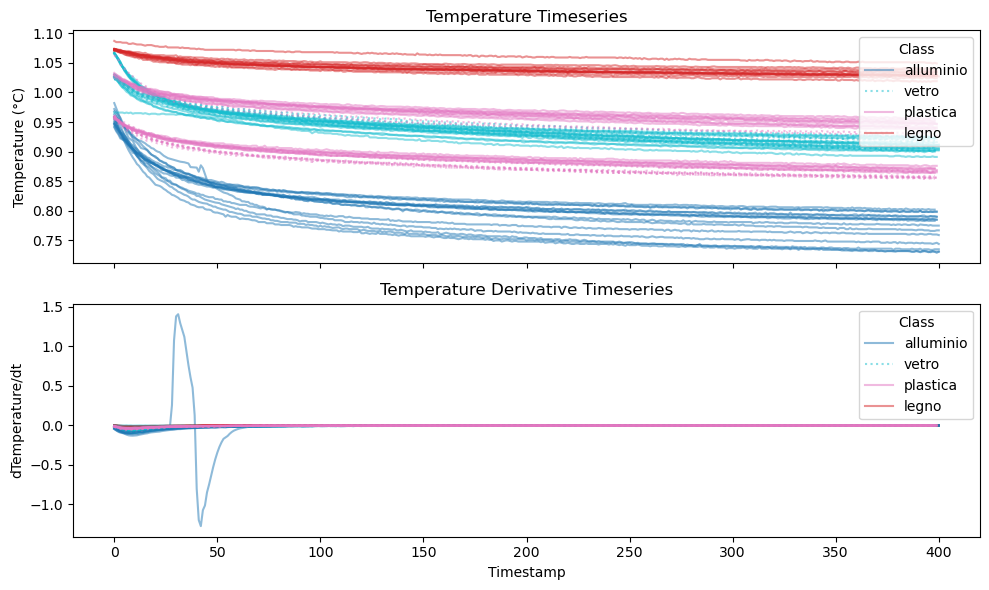

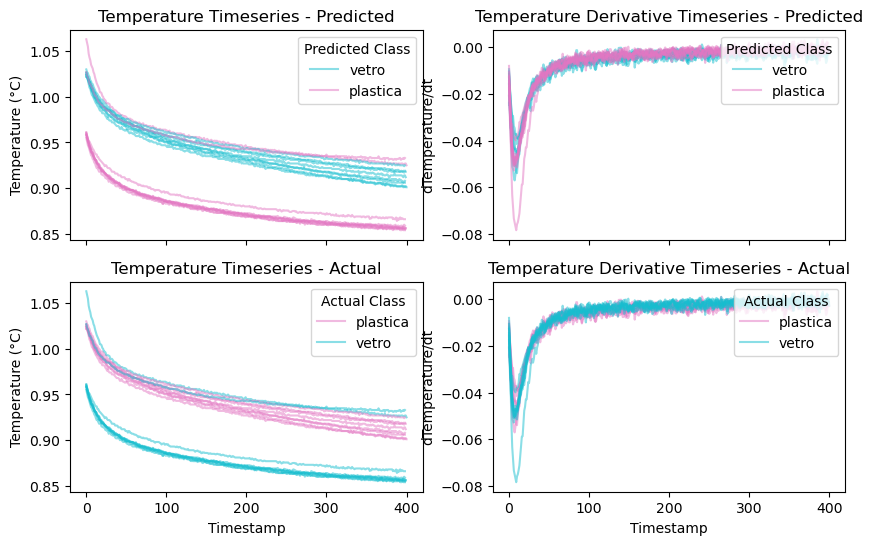

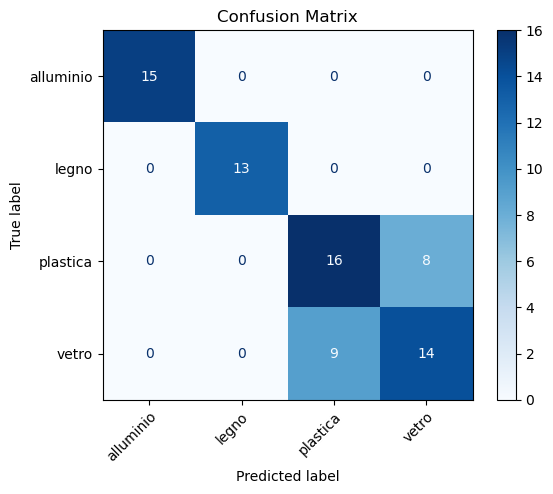

In [47]:
# Prediction plot
colors = plt.cm.tab10(np.linspace(0, 1, len(classifier.dataset_manager.class_names)))    
plotted_labels = []

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
for idx, row in enumerate(dataset_manager_test):
    data = row[0].numpy()  # row is assumed to be shape (400, 2)
    temp = data[:, 0]
    dtemp = data[:, 1]
    
    # Set line style and color based on error
    if error[idx] == 0:
        linestyle = '-'     # solid line
        color = 'green'
    else:
        linestyle = ':'     # dotted line
        color = 'red'
    color = colors[list_label_prediction[idx]] # color according to prediction class
    label_name = classifier.dataset_manager.class_names[list_label_prediction[idx]]

    # Plot temperature
    if label_name not in plotted_labels:
        axs[0].plot(range(len(temp)), temp, alpha=0.5, color=color, linestyle=linestyle, label=label_name)
        axs[1].plot(range(len(dtemp)), dtemp, alpha=0.5, color=color, linestyle=linestyle, label=label_name)
        plotted_labels.append(label_name)
    else:
        axs[0].plot(range(len(temp)), temp, alpha=0.5, color=color, linestyle=linestyle, label='_nolegend_')
        axs[1].plot(range(len(dtemp)), dtemp, alpha=0.5, color=color, linestyle=linestyle, label='_nolegend_')

axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature Timeseries')
axs[0].legend(title="Class", loc="upper right")

axs[1].set_ylabel('dTemperature/dt')
axs[1].set_xlabel('Timestamp')
axs[1].set_title('Temperature Derivative Timeseries')
axs[1].legend(title="Class", loc="upper right")

plt.tight_layout()
plt.show()


# Plot only the errors
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True) 
plotted_labels = []
actual_plotted_labels = []
for idx, row in enumerate(dataset_manager_test):
    if error[idx] == 1:  # Only plot errors
        data = row[0].numpy()  # row is assumed to be shape (400, 2)
        temp = data[:, 0]
        dtemp = data[:, 1]
        
        color = colors[list_label_prediction[idx]]  # color according to prediction class
        actual_color = colors[list_label_gt[idx]]  # color according to actual class

        label_name = classifier.dataset_manager.class_names[list_label_prediction[idx]]
        actual_label_name = classifier.dataset_manager.class_names[list_label_gt[idx]]
        if label_name not in plotted_labels:
            axs[0,0].plot(range(len(temp)), temp, alpha=0.5, color=color, linestyle='-', label=label_name)
            axs[0,1].plot(range(len(dtemp)), dtemp, alpha=0.5, color=color, linestyle='-', label=label_name)
            plotted_labels.append(label_name)
        else:
            axs[0,0].plot(range(len(temp)), temp, alpha=0.5, color=color, linestyle='-', label='_nolegend_')
            axs[0,1].plot(range(len(dtemp)), dtemp, alpha=0.5, color=color, linestyle='-', label='_nolegend_')

        if actual_label_name not in actual_plotted_labels:
            axs[1,0].plot(range(len(temp)), temp, alpha=0.5, color=actual_color, linestyle='-', label=actual_label_name)
            axs[1,1].plot(range(len(dtemp)), dtemp, alpha=0.5, color=actual_color, linestyle='-', label=actual_label_name)
            actual_plotted_labels.append(actual_label_name)
        else:
            axs[1,0].plot(range(len(temp)), temp, alpha=0.5, color=actual_color, linestyle='-', label='_nolegend_')
            axs[1,1].plot(range(len(dtemp)), dtemp, alpha=0.5, color=actual_color, linestyle='-', label='_nolegend_')

axs[0,0].set_ylabel('Temperature (°C)')
axs[0,0].set_title('Temperature Timeseries - Predicted')
axs[1,0].set_ylabel('Temperature (°C)')
axs[1,0].set_title('Temperature Timeseries - Actual')
axs[0,1].set_ylabel('dTemperature/dt')
axs[0,1].set_title('Temperature Derivative Timeseries - Predicted')
axs[1,1].set_ylabel('dTemperature/dt')
axs[1,1].set_title('Temperature Derivative Timeseries - Actual')
axs[1,1].set_xlabel('Timestamp')
axs[1,0].set_xlabel('Timestamp')
axs[0,0].legend(title="Predicted Class", loc="upper right")
axs[0,1].legend(title="Predicted Class", loc="upper right")
axs[1,0].legend(title="Actual Class", loc="upper right")
axs[1,1].legend(title="Actual Class", loc="upper right")
plt.show() 



# Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(
        list_label_gt,
        list_label_prediction,
        display_labels = dataset_manager_test.class_names,
        cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()



In [35]:
# Extract succesfull experiment
to_skip = 0
desired_label = 0  # Change this to the desired label index

skip=0
for idx, row in enumerate(dataset_manager_test):
    data = row[0].numpy()  # row is assumed to be shape (400, 2)
    temp = data[:, 0]
    dtemp = data[:, 1]
    
    # Set line style and color based on error
    if error[idx] == 1:
        continue  # skip errors

    if list_label_prediction[idx] != desired_label:
        continue

    if skip<to_skip:
        skip += 1
        continue
    
    # Plot temperature
    print(f" Class: {classifier.dataset_manager.class_names[list_label_prediction[idx]]}")
    print(f" Scores: {scores[idx]}")
    df = pd.DataFrame({
        'Temperature': temp,
        'dTemperature': dtemp
    })
    #df.to_csv('csv_to_plot.csv', index=False)


    break

 Class: alluminio
 Scores: [0.37860566 0.06422905 0.2032835  0.35388187]
